# Predicting NBA All-Star Chance Based on Player Performance

By: Bill Makwae, Ayush Vora, Ray Nguyen, QingRu Kong <br/>
Modified by: Ray Nguye, Jeffrey Song, Emilio Dorador, Berkay Talha Acar

## Introduction

Every year in February, NBA fans rejoice as they get to see their favorite players selected for the all-star game. Players are selected by media and fan votes, meaning that popularity is the nominating factor. However, players are more likely to be popular based on their individual game-to-game performance (Grimshaw & Larson, 2020). Thus, this analysis hopes to answer the question: **Can an NBA player’s selection to the all star game be predicted by their annual performance?**

In order to answer this question, we will be using two sets of data, one from ["NBA Player Stats” on nba.com](https://www.nba.com/stats/players/traditional/?sort=PTS&dir=-1&Season=2015-16&SeasonType=Regular%20Season) and [“NBA All Stars 2000-2016” from kaggle.com](https://www.kaggle.com/fmejia21/nba-all-star-game-20002016?select=NBA+All+Stars+2000-2016+-+Sheet1.csv). NBA Player Stats includes all the NBA player statistics for each season from 2010-2016 and the All Star dataset includes the all star statistics from 2000-2016. Using these datasets we aim to make a classification model that will predict whether a player will be an all star for each season based on their annual performances.

The variables that we will be looking at for this data set are the following:
- Year: Season that the player played.
- Player: Name of the player.
- MIN: Average number of minutes that the player played per game.
- PTS: Average number of points that the player scored per game.
- FG.: Field Goal Percentage.
- REB: Average number of rebounds that the player made per game.
- AST: Average number of assists that the player got per game.
- Is_All_Star: Whether the player was an All-Star in that season. **This is our classifer.**

We chose these variables because they are the most indicative of a player's offensive output, which is the main focus of the all star game(Nguyen et al., 2021).

## Methods and Results

Because the Themis package is not installed automatically, we must manually install it. 

The following are libraries that are essential for the model to be created. 
- The Tidyverse library includes packages necessary for common data analysis tasks.
- The GGally library helps create complex graphs necessary for visualizing data.
- The Tidymodels library helps create the classification model.
- The Themis library helps with balancing the data points to provide more accurate results.

In [13]:
#install.packages("themis")
library(tidyverse)
library(GGally)
library(tidymodels)
library(themis)
source("R/01_season_filter.R")
source("R/02_get_all_stars.R")
source("R/03_visualize.R")
set.seed(2022)

**Table 1.** List of All Star players in the all_star dataset from 2011-2015

The dataset is generated is a combination of two datasets which filtered using a left joint method specified in the function getallstars(). The final dataset only keeps allstar players specified in the year range. Below is a sample of the output.

In [16]:
combined_data <- getallstars(2011,2015)
head(combined_data)

,Year,Player,GP,MIN,PTS,FGM,FGA,FG.,X3PM,X3PA,⋯,FTA,FT.,OREB,DREB,REB,AST,STL,BLK,TOV,Is_All_Star
,<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,2011,Kevin Durant,78,38.9,27.7,9.1,19.7,46.2,1.9,5.3,⋯,8.7,88.0,0.7,6.1,6.8,2.7,1.1,1.0,2.8,All Star
2,2011,LeBron James,79,38.8,26.7,9.6,18.8,51.0,1.2,3.5,⋯,8.4,75.9,1.0,6.5,7.5,7.0,1.6,0.6,3.6,All Star
3,2011,Carmelo Anthony,77,35.7,25.6,8.9,19.5,45.5,1.2,3.3,⋯,7.9,83.8,1.5,5.8,7.3,2.9,0.9,0.6,2.7,All Star
4,2011,Dwyane Wade,76,37.1,25.5,9.1,18.2,50.0,0.8,2.7,⋯,8.6,75.8,1.6,4.8,6.4,4.6,1.5,1.1,3.1,All Star
5,2011,Kobe Bryant,82,33.9,25.3,9.0,20.0,45.1,1.4,4.3,⋯,7.1,82.8,1.0,4.1,5.1,4.7,1.2,0.1,3.0,All Star
6,2011,Amar'e Stoudemire,78,36.8,25.3,9.5,19.0,50.2,0.1,0.3,⋯,7.7,79.2,2.5,5.6,8.2,2.6,0.9,1.9,3.2,Regular


**Table 2.** Further filtering of dataset.

We used `filter()` to filter for Year from 2011 to 2015 and filtered out player than equal to 0 to ensure all the data set we have are valid data points. We then used `select()` function to pick out desirable columns (Year, Player, MIN, PTS, FGM, FGA, FTM, FTA, TOV, Is_All_Star) for our classification model.

In [17]:
selected_combined_data <- season_filter(combined_data, Year, 2011, 2015) %>%
    filter(Player != "0") %>%
    select(Year, Player, MIN, PTS, FGM, FGA, FTM, FTA, TOV, Is_All_Star)
head(selected_combined_data)

,Year,Player,MIN,PTS,FGM,FGA,FTM,FTA,TOV,Is_All_Star
,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,2011,Kevin Durant,38.9,27.7,9.1,19.7,7.6,8.7,2.8,All Star
2,2011,LeBron James,38.8,26.7,9.6,18.8,6.4,8.4,3.6,All Star
3,2011,Carmelo Anthony,35.7,25.6,8.9,19.5,6.6,7.9,2.7,All Star
4,2011,Dwyane Wade,37.1,25.5,9.1,18.2,6.5,8.6,3.1,All Star
5,2011,Kobe Bryant,33.9,25.3,9.0,20.0,5.9,7.1,3.0,All Star
6,2011,Amar'e Stoudemire,36.8,25.3,9.5,19.0,6.1,7.7,3.2,Regular


**Table 3: Summary Table.** The above table provides the first 6 rows of the summary table that we are using as training and testing data.

We used set.seed(2022) to ensure the same set of data is used and the data set is reproducible. Used `initial_split()` function to split the data set into 70:30 ratio of training and testing data. We choose 70:30 ratio because it is an optimal ratio to represent the training and testing data, as we want to maximize data used for training but still leave some data left for testing the classification model. `Is_All_Star` is assigned as the strata because it is the classifier we want to find. 70% of the data is assigned to data_training using `training()`, and 30% of the data is assigned to data_testing using `testing()`. Finally, the `head()` function is used to show the first 6 column of the training data.


In [18]:
set.seed(2022)
data_split <- initial_split(selected_combined_data, prop = 0.7, strata = Is_All_Star)
data_training <- training(data_split)
data_testing <- testing(data_split)

We want to calculate the average for each variable by first group the observations by `Is_All_Star` and then use `summarize()` to compute the means. 

In [19]:
averages <- group_by(data_training, Is_All_Star) %>% 
    summarize(across(MIN:TOV, mean))
averages


Is_All_Star,MIN,PTS,FGM,FGA,FTM,FTA,TOV
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
All Star,35.00896,19.87463,7.217910,15.159701,4.343284,5.39403,2.511940
Regular,25.66599,10.41489,3.936496,8.645547,1.772263,2.34219,1.424088


**Table 5.** The above data table shows the mean statistics of All Star players verse Regular players

We still group by `Is_All_Star` and use summarize to calculate the number of observations for each group then divide by the total number of observations.

In [20]:
proportion <- group_by(data_training, Is_All_Star) %>% 
    summarize(Counts = n()) %>% 
    mutate(Percent = 100*Counts/nrow(data_training))

proportion

Is_All_Star,Counts,Percent
<fct>,<int>,<dbl>
All Star,67,8.909574
Regular,685,91.090426


**Table 6.** The above data table shows the percentage and count of all star players and regular players in the overall dataset. 

We use `ggpairs()` from the GGally library to make a scatterplot for every pair of variables to visualize the relationship between them. By doing so, we can see what variables truly distinguish All Star players from regular players.

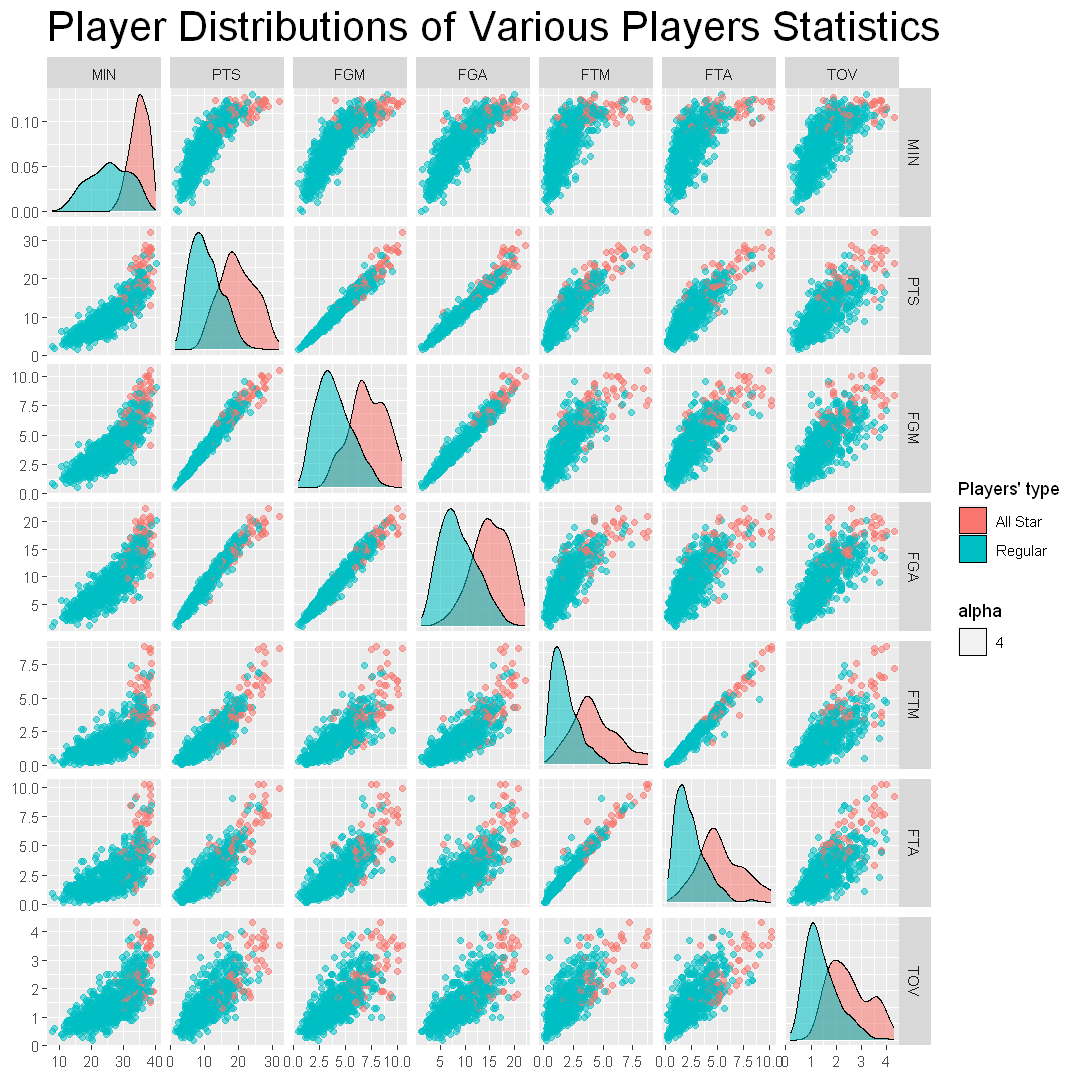

In [21]:
set.seed(2022)

options(repr.plot.width = 9, repr.plot.height = 9) 
# plot <- ggpairs(data_training, columns = 3:9, legend = 1,
#                 ggplot2::aes(color = Is_All_Star, alpha = 0.4),
#                 upper = list(continuous = "points", wrap("cor", size = 2.5))) +
#                 labs(title = "Player Distributions of Various Players Statistics", fill = "Players' type") +
#                 theme(plot.title = element_text(size = 25))
plot <- visualize_distributions(data_training, feature_start = 3, feature_end = 9, alpha = 4)                
plot

**Figure 1: Visualization for the summary data.**: Above is a group of graphs generated via ggpair that compares all of the varibles (MIN, PTS, FGM, FGA, FTM, FTA, TOV, Is_All_Star). As we can see from above, all the graphs shows a postive correlation in a semi-linear trend, with All Star players having a higher perfromance than Regular players. The density plot in the diagonal line shows the density distribution of All Star player vs. Regular. With the positive correlation, we decided to use the variables graphed in our predition model to predict whether or not a high player performance will yield to a high rate of earning the all star title.  

Cross validation(`vfold_cv`) will give us a higher accuracy as it split our training data into 4 training and 1 testing. This way, there would be 5 tests done to evalute the accuracy of the model instead of just one. We chose to fold by 5 because our dataset is quite large, folidng by 10 will take too much time for the kernal to run. We create the `k-vals` data frame with the “neighbors” variable containing values from 1 to 70, stepping by 5, using the seq function. After experimenting with different K ranging, 1 to 70 stepping by 5 run in a relatively short period of time while giving us a decent K range, therefore we chose it as our K range.

Then, we create a recipe by setting the classifier to be `Is_All_Star` and the rest are predictors. Next, we centered and scale the data with `step_center()` and `step_scale()`. After, we balanced the data using `step_upsample()`, since All-Stars only make up 10% of the dataset (as shown by `proportions`), now the all star and regular varible will be at a 1:1 ratio. Afterwards, we created a tuning model specification for K-nearest neighbors classification by calling `nearest_neighbors()` and setting the engine to be “kknn” with `set_engine()` and the model to be “classification” with `set_mode()`. We chose classification because our classifier is a factor, and we are trying to find whether a player will be all star or regular player which does not involve numeric value output.

Lastly, we add the recipe and the model specification into a workflow and let it run the cross validation test on data_fold by passing k_vals into grid argument of `tune_grid()`. Then we use `collect_metrics()` and `filter()` to only look at the “accuracy” part of .metric to acquire the accuracy of our model for each K.



In [22]:
set.seed(2022)

data_fold <- vfold_cv(data_training, v = 5, strata = Is_All_Star)

k_vals <- tibble(neighbors = seq(from = 1, to = 70, by = 5))

data_recipe <- recipe(Is_All_Star ~ MIN + PTS + FGM + FGA + FTM + FTA + TOV, data = data_training) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors()) %>% 
    step_upsample(Is_All_Star, over_ratio =1, skip = TRUE)


data_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")

data_fit <- workflow() %>%
    add_recipe(data_recipe) %>%
    add_model(data_spec) %>%
    tune_grid(resamples = data_fold, grid = k_vals) %>%
    collect_metrics() %>%
    filter(.metric == "accuracy")

When we graphed the various possible K values by accuracy, it seemed like 1 is a good K but this is not accurate because it leads to overfitting. Instead, we chose an odd number that is near 60, such as 61. As we have experimented, any K value ranging from 30-70 does not make too much difference to the accuracy of predicting the All Star player, therefore, we chose 61 as it has the highest model accuracy rate within the 30-70 K range.


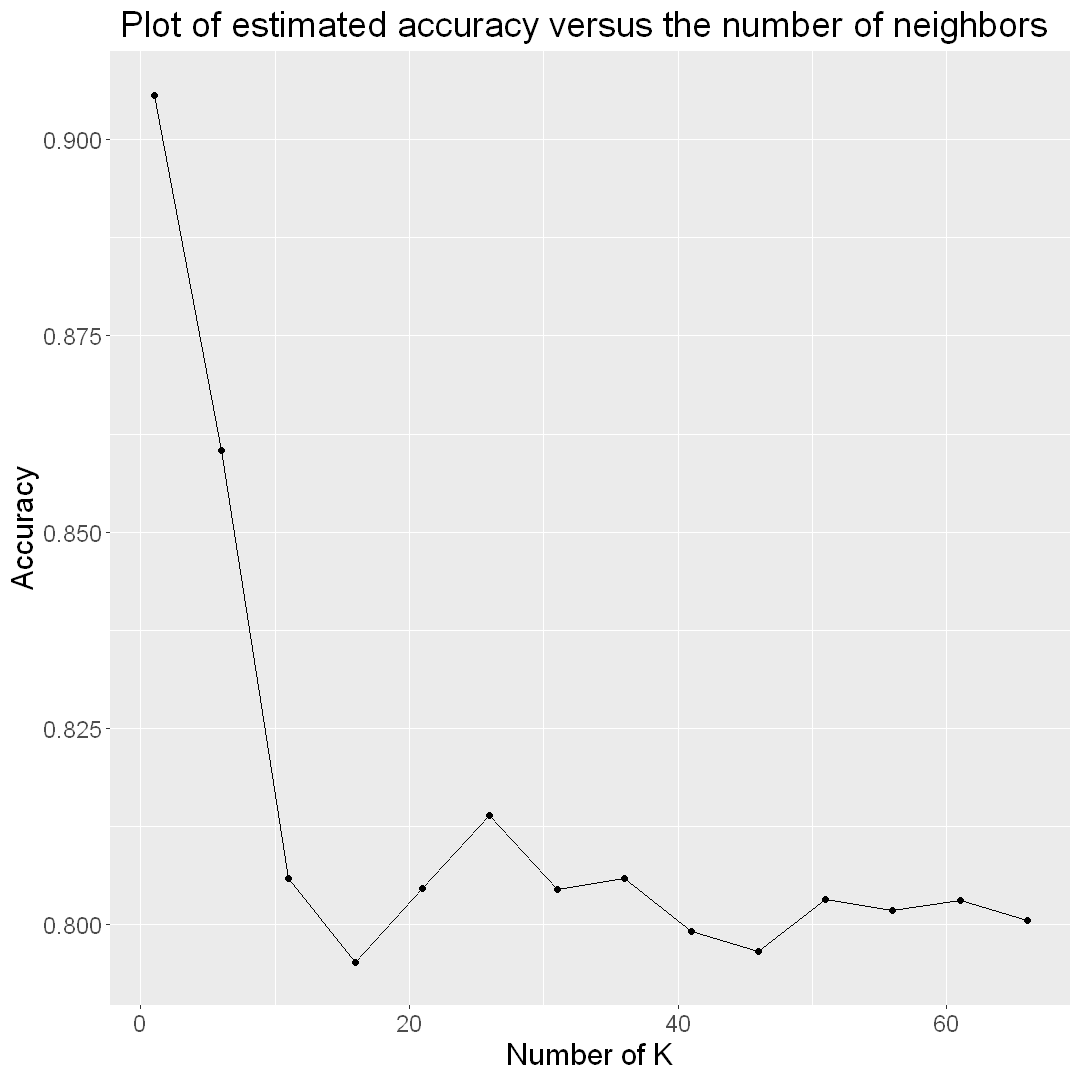

In [23]:
data_plot <- ggplot(data_fit, aes(x = neighbors, y = mean)) +
    geom_line() +
    geom_point() +
    xlab("Number of K") +
    ylab("Accuracy") + theme(text = element_text(size = 18)) + ggtitle(" Plot of estimated accuracy versus the number of neighbors")

data_plot

**Figure 2**. The above graph shows the accuracy for each neighbour input. The highest accuracy is near the first K. A steep decline to 0.825 when we have one neighbour vs 15 neighbours and a gentle decline from 15-32 neighbours. Starting from ~32 neighbours the accuracy increase to a small peak every 10 neighbours and decline by half every 10 neighbours. 

After we determined the best K value for our model, we updated our model by setting neighbours to 61. Then, we updated the workflow to add the recipe, the updated model, and fit the training data with `fit()`. We are using the testing data as this is used to test the accuracy of our model with data unseen before. Finally, we used the `predict()` function with our model and our testing data to see how well our model performed. Then, we binded our columns with the testing data to see the data and predictions side-by-side. 

In [24]:
data_updated_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 61) %>%
    set_engine("kknn") %>%
    set_mode("classification")

data_updated_fit <- workflow() %>%
    add_recipe(data_recipe) %>%
    add_model(data_updated_spec) %>%
    fit(data_training)

data_prediction <- predict(data_updated_fit, data_testing) %>%
    bind_cols(data_testing)


We found the accuracy of the classifier by using the `metrics()` function on the data_prediction dataframe. By setting the truth parameter to Is_All_Star and the estimate parameter to .pred_class, we ended up with a frame of data metrics for when our classifier tries to predict the All Star players. We then filtered the .metric column by the accuracy tag with `filter()` and selected the .estimate column to find the accuracy of our model with `select()`. The overall accuracy of our predication model is 80.7%.


In [25]:
data_metrics <- metrics(data_prediction, truth = Is_All_Star, estimate = .pred_class) %>%
    filter(.metric == "accuracy") %>%
    select(.estimate) %>%
    pull()

data_metrics

[1] 0.8452012

Next, we used conf_mat() on the data_prediction data frame to create a confusion matrix of our classifier’s results. Which shows that our All Star prediction accuracy is 23/26(88.5%), and regular prediction accuracy is 237/296 (80.1%).

In [26]:
confusion <- conf_mat(data_prediction, truth = Is_All_Star, estimate = .pred_class)
confusion

          Truth
Prediction All Star Regular
  All Star       33      48
  Regular         2     240

**Table 7: Final Data Table.** Above is a confusion matrix displaying how many All Star and Regular our model prediction is correct and wrong. Out of 26 All Star, our model predicted 23 All Star correctly and 3 wrong. Out of 296 Regular players, 237 players are predicted correcly and 59 were predicted wrong. This brings our accuacry of All Star to 88.5%.

We created a data frame based on the confusion matrix above using the `tibble()` function. Then we plotted a percent stacked bar graph with the correctness ratio on the y axis and All Star or Regular label on the x axis. This graph shows that the model is more accurate when predicting the All Star players than the Regular players, but both still have a high accuracy.

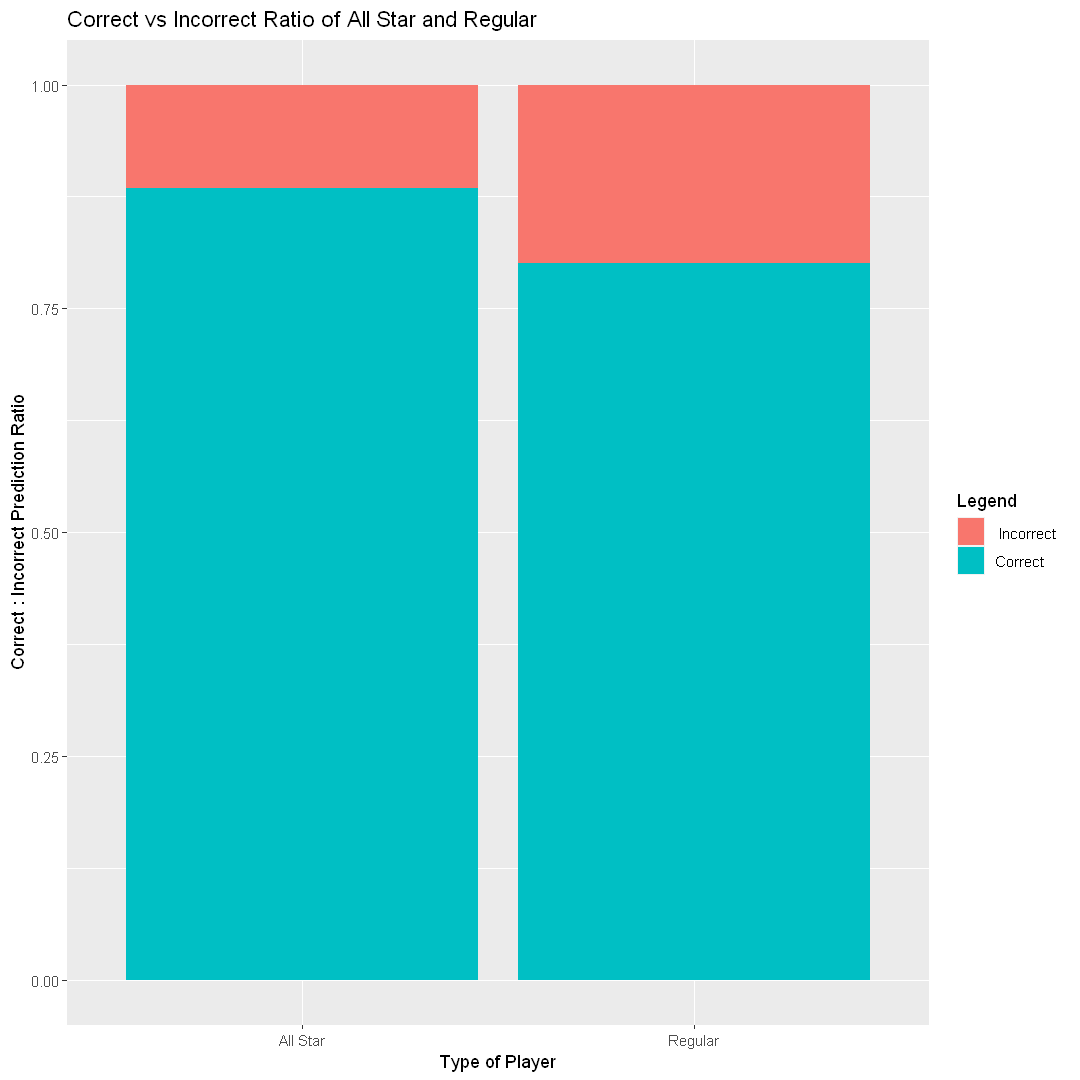

In [27]:
confusion_tibble <- tibble(all_star = c("All Star", "All Star", "Regular", "Regular"), 
                           correctness = c(" Incorrect", "Correct", " Incorrect", "Correct"),
                           value = c(3, 23, 59, 237))
confusion_graph <- ggplot(confusion_tibble, aes(x = all_star, y = value, fill = correctness)) +
    geom_bar(stat = "identity", position = "fill") +
    labs(x = "Type of Player", y = "Correct : Incorrect Prediction Ratio", fill = "Legend", title = "Correct vs Incorrect Ratio of All Star and Regular")

confusion_graph

**Figure 3: Final Visualization** The blue shade represent the players that our model predicted correctly, while the red shaded area represent the palyers that our model predicted incorrectly. Overall 0.885 of all star players was predicted correctly, while 0.801 of the regular players were predicted correctly.


## Discussion

#### Summarize what you found


We found that using our classifier correctly identified a player to be an all-star 88.5% of the time. This is shown by our confusion matrix where 23/26 all-stars were correctly identified. However, the classifier incorrectly classified regular players as all-stars 59/256. This reduced our overall prediction accuracy to 80.1%. As a general takeaway, the higher a player's statistics (at least the ones we observed in this study) meant that a player was more likely to be an all-star.

#### Discuss whether this is what you expected to find?


This analysis went as expected. We initially thought that higher player statistics would be a good identifier of an all-star player, and our classifier showed this. Our classifier was able to improve the accuracy of identifying an all-star player by over 44.5% percent over a fifty-fifty guess model.

#### Discuss what impact could such findings have?


The impact of our findings could include: helping organizations determine player value when negotiating player contracts to maximize the return outcome of their investment, determining trade value, and even the overall organization value. Our model would also allow teams to focus resources on certain players in order to increase their chance of earning the all star title.

#### Discuss what future questions could this lead to?


Future studies could look at weighing the different player statistics differently based on their perceived value, and see if there are certain statistics that are more influential in predicting a player’s all-star status. Another study could look at classifying whether a player is a good fit for the team, as the player could address any weaknesses in their offense or defense. 

## Work Cited

1. Grimshaw, S. D., &amp; Larson, J. S. (2020). Effect of star power on NBA all-star game TV audience. Journal of Sports Economics, 22(2), 139–163. https://doi.org/10.1177/1527002520959127 
2. Nguyen, N. H., Nguyen, D. T., Ma, B., &amp; Hu, J. (2021). The application of machine learning and Deep Learning in sport: Predicting NBA players’ performance and popularity. Journal of Information and Telecommunication, 1–19. https://doi.org/10.1080/24751839.2021.1977066 
3. Nguyen, N., Ma, B., Hu, J. (2020). Predicting National Basketball Association Players Performance and Popularity: A Data Mining Approach. In: Nguyen, N.T., Hoang, B.H., Huynh, C.P., Hwang, D., Trawiński, B., Vossen, G. (eds) Computational Collective Intelligence. ICCCI 2020. Lecture Notes in Computer Science(), vol 12496. Springer, Cham. https://doi.org/10.1007/978-3-030-63007-2_23
4. Liu, Y. (2021). Star players in the NBA - decoys or game-changers? Canadian Center of Science and Education. doi:10.5539/jmr.v13n2p40